In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
### DATASET SETUP ###
print("Loading CIFAR-10 dataset...")
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Split the original training set into train and validation (4:1 ratio)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=10000, random_state=42
)

print(f"Training samples: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training samples: 40000
Validation samples: 10000
Test samples: 10000


In [4]:
### MODEL BUILDING FUNCTIONS ###
def create_cnn_model(conv_layers=2, filters=[32, 64], kernel_size=3, pooling_type='max'):
    """
    Creates a CNN model based on the given parameters.

    Args:
        conv_layers: Number of convolutional layers
        filters: List of filter counts for each convolutional layer
        kernel_size: Size of the convolutional kernel
        pooling_type: Type of pooling ('max' or 'avg')

    Returns:
        Compiled Keras model
    """
    model = keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=(32, 32, 3)))

    # Add convolutional layers based on parameters
    for i in range(min(conv_layers, len(filters))):
        model.add(layers.Conv2D(
            filters=filters[i],
            kernel_size=kernel_size,
            padding='same',
            activation='relu'
        ))

        # Add pooling layer after each conv layer
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        else:  # 'avg'
            model.add(layers.AveragePooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10))  # 10 classes for CIFAR-10

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# Custom F1 Score callback
class MacroF1Score(keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MacroF1Score, self).__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_val.flatten(), y_pred_classes, average='macro')
        self.f1_scores.append(f1)
        print(f" - val_f1_score: {f1:.4f}")

def train_and_evaluate_model(model, epochs=10, batch_size=64):
    """
    Trains and evaluates a model.

    Args:
        model: Compiled Keras model
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        history: Training history
        f1_callback: F1 score callback with validation scores
    """
    # Create callback for F1 score
    f1_callback = MacroF1Score(validation_data=(x_val, y_val.flatten()))

    # Early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[f1_callback, early_stopping]
    )

    # Evaluate on test set
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    test_f1 = f1_score(y_test, y_pred_classes, average='macro')
    print(f"Test Macro F1 Score: {test_f1:.4f}")

    return history, f1_callback.f1_scores, test_f1

def plot_training_history(history, title="Training History", include_f1=None):
    """
    Plots the training history.

    Args:
        history: Training history from model.fit
        title: Title for the plot
        include_f1: List of F1 scores to plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # Plot F1 score if provided
    if include_f1 is not None:
        epochs = len(include_f1)
        ax2.plot(range(epochs), include_f1, label='Validation Macro F1')

    ax2.set_title(f'{title} - Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()

    plt.tight_layout()
    return fig


=== Experiment a: Varying Number of Convolutional Layers ===

Training model with 1 convolutional layer(s)...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.4539
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.2622 - loss: 1.9950 - val_accuracy: 0.4604 - val_loss: 1.5034
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5257
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4270 - loss: 1.5632 - val_accuracy: 0.5298 - val_loss: 1.3332
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5457
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4702 - loss: 1.4595 - val_accuracy: 0.5493 - val_loss: 1.2832
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5734
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4903 - loss: 1.4002 - val_accuracy: 0.5788 - val_loss: 1.2186
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5862
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/st

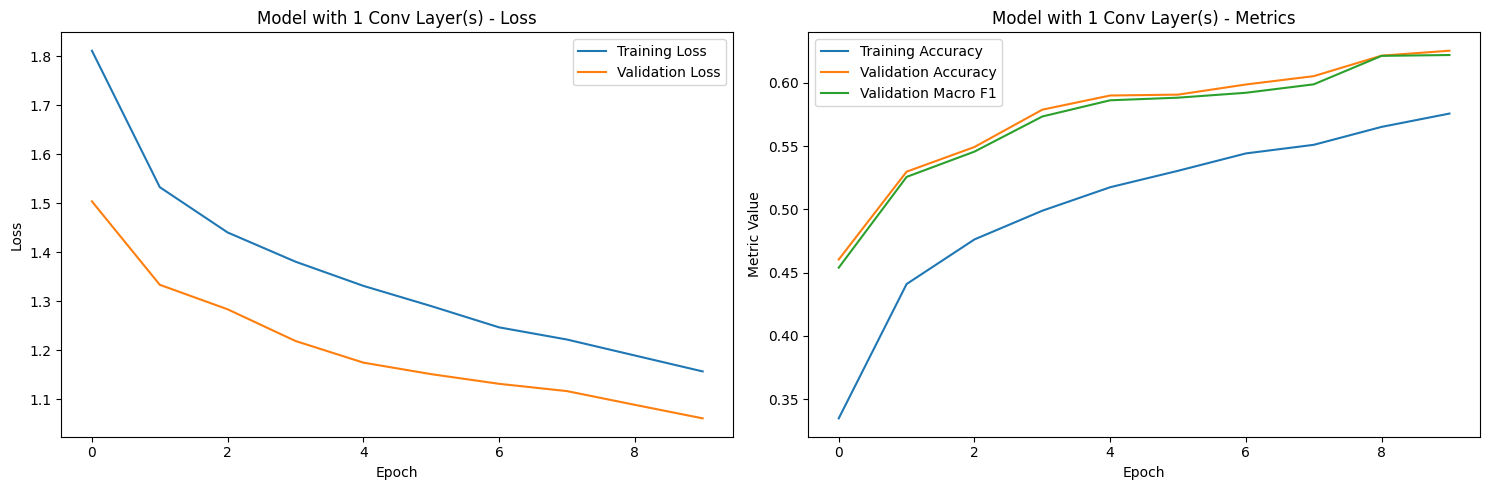


Training model with 2 convolutional layer(s)...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5026
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2971 - loss: 1.9057 - val_accuracy: 0.5161 - val_loss: 1.3683
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5715
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4821 - loss: 1.4267 - val_accuracy: 0.5732 - val_loss: 1.2200
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5943
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5423 - loss: 1.2755 - val_accuracy: 0.5941 - val_loss: 1.1406
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6246
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5841 - loss: 1.1758 - val_accuracy: 0.6233 - val_loss: 1.0636
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6248
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6099 - loss: 1.1103 - val_accuracy: 0.6223 - val

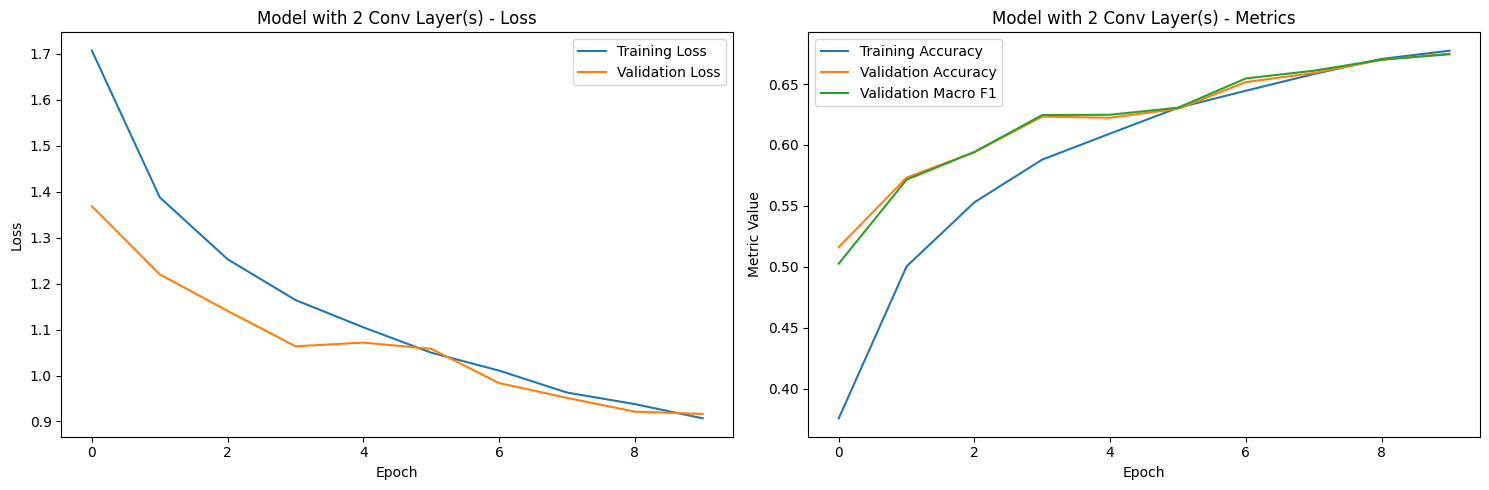


Training model with 3 convolutional layer(s)...
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.4852
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.2600 - loss: 1.9827 - val_accuracy: 0.4901 - val_loss: 1.4211
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5568
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4792 - loss: 1.4461 - val_accuracy: 0.5595 - val_loss: 1.2309
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5902
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5401 - loss: 1.2877 - val_accuracy: 0.5883 - val_loss: 1.1625
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.6249
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5813 - loss: 1.1843 - val_accuracy: 0.6237 - val_loss: 1.0573
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6421
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6111 - loss: 1.1037 - val_accuracy: 0.6427 - v

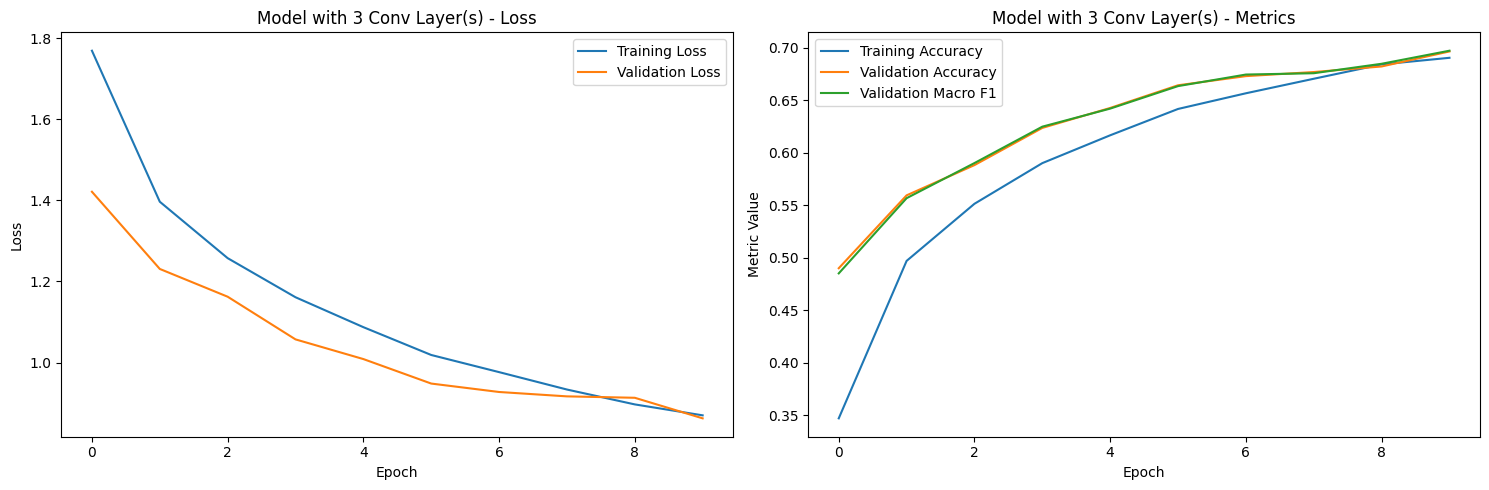

In [5]:
### EXPERIMENT EXECUTION ###
# a. VARYING NUMBER OF CONVOLUTIONAL LAYERS
print("\n=== Experiment a: Varying Number of Convolutional Layers ===")
conv_layer_results = []

for num_layers in [1, 2, 3]:
    print(f"\nTraining model with {num_layers} convolutional layer(s)...")
    model = create_cnn_model(
        conv_layers=num_layers,
        filters=[32] * num_layers,  # Same number of filters for all layers
        kernel_size=3,
        pooling_type='max'
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    conv_layer_results.append({
        'num_layers': num_layers,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with {num_layers} Conv Layer(s)",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment b: Varying Number of Filters ===

Training model with filters: 16-32
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5262
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3030 - loss: 1.8955 - val_accuracy: 0.5317 - val_loss: 1.3335
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5765
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4958 - loss: 1.4069 - val_accuracy: 0.5829 - val_loss: 1.1899
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6112
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5549 - loss: 1.2564 - val_accuracy: 0.6146 - val_loss: 1.1014
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6395
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5881 - loss: 1.1652 - val_accuracy: 0.6399 - val_loss: 1.0381
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.6490
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6136 - loss

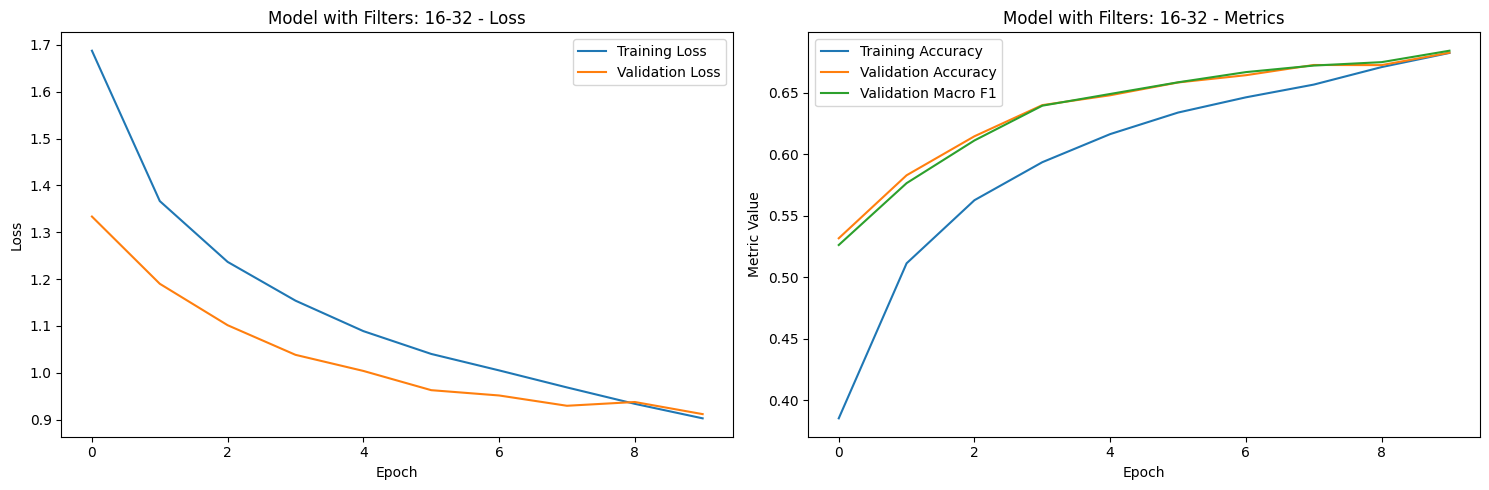


Training model with filters: 32-64
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.5018
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2900 - loss: 1.9103 - val_accuracy: 0.5162 - val_loss: 1.3489
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5723
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4783 - loss: 1.4404 - val_accuracy: 0.5761 - val_loss: 1.1956
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6176
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5295 - loss: 1.2927 - val_accuracy: 0.6217 - val_loss: 1.0864
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6380
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5719 - loss: 1.1951 - val_accuracy: 0.6392 - val_loss: 1.0446
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6531
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5987 - loss: 1.1242 - val_accuracy: 0.6531 - val_loss: 0.998

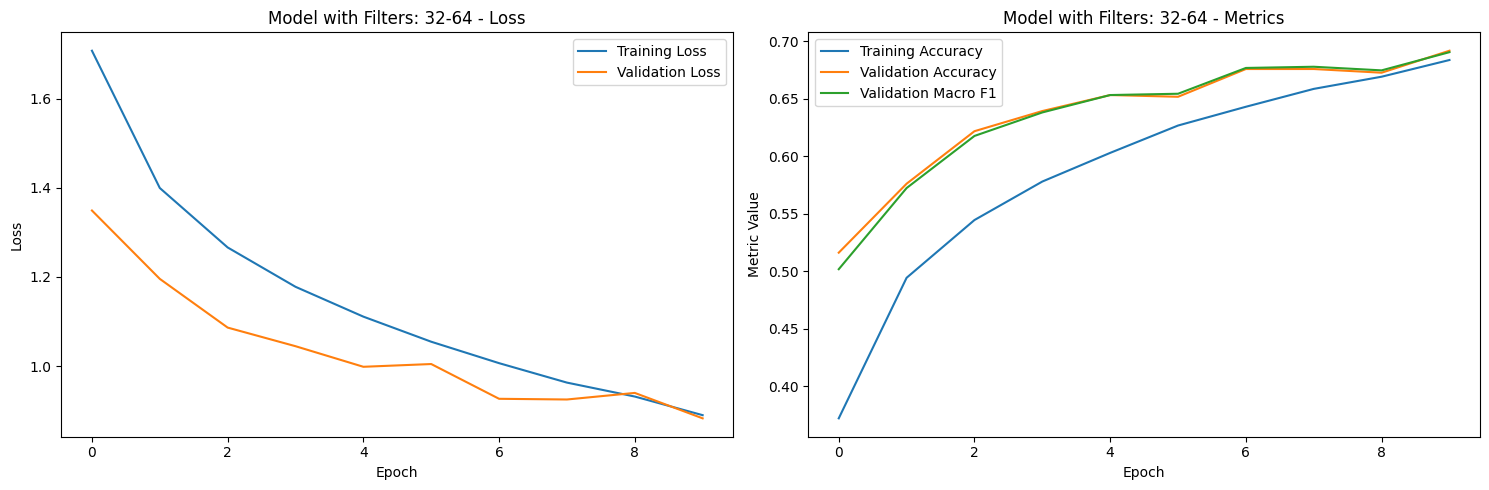


Training model with filters: 64-128
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.5131
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2872 - loss: 1.9133 - val_accuracy: 0.5265 - val_loss: 1.3396
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5861
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4794 - loss: 1.4466 - val_accuracy: 0.5910 - val_loss: 1.1556
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.6305
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5380 - loss: 1.2881 - val_accuracy: 0.6282 - val_loss: 1.0591
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6536
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5778 - loss: 1.1876 - val_accuracy: 0.6532 - val_loss: 0.9888
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6640
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6027 - loss: 1.1188 - val_accuracy: 0.6630 - val_loss:

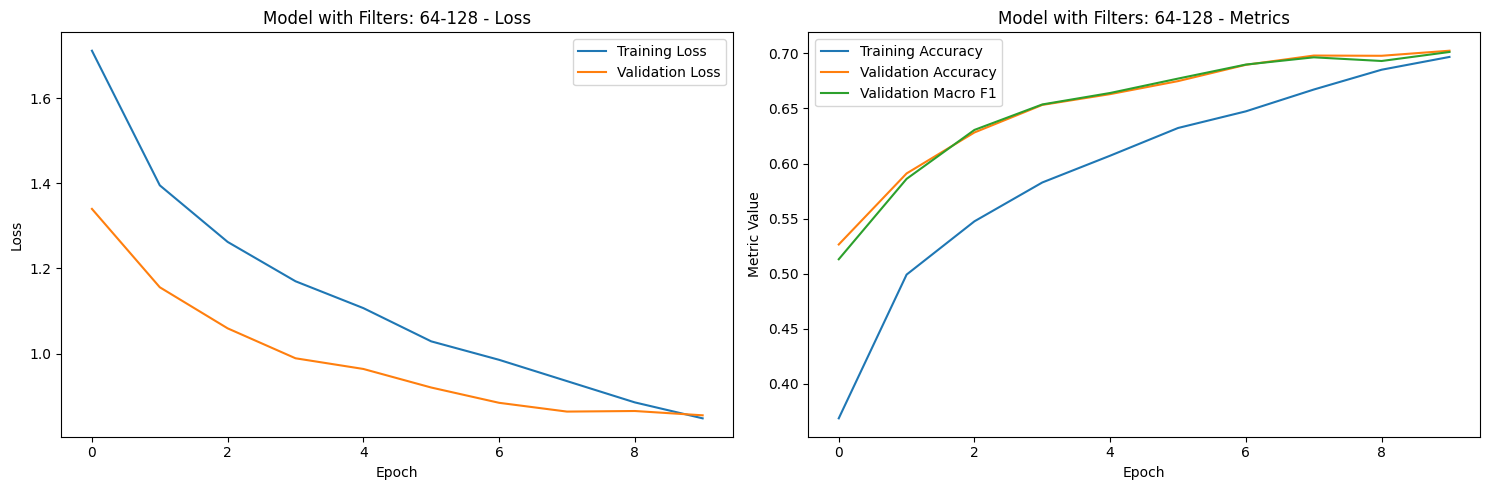

In [6]:
# b. VARYING NUMBER OF FILTERS
print("\n=== Experiment b: Varying Number of Filters ===")
filter_results = []

filter_configs = [
    [16, 32],
    [32, 64],
    [64, 128]
]

for filters in filter_configs:
    filter_str = '-'.join(map(str, filters))
    print(f"\nTraining model with filters: {filter_str}")
    model = create_cnn_model(
        conv_layers=len(filters),
        filters=filters,
        kernel_size=3,
        pooling_type='max'
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    filter_results.append({
        'filters': filters,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with Filters: {filter_str}",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment c: Varying Kernel Size ===

Training model with kernel size: 3
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5047
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2960 - loss: 1.9005 - val_accuracy: 0.5134 - val_loss: 1.3476
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5934
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4935 - loss: 1.4008 - val_accuracy: 0.5973 - val_loss: 1.1446
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6293
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5591 - loss: 1.2331 - val_accuracy: 0.6296 - val_loss: 1.0697
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6497
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5947 - loss: 1.1496 - val_accuracy: 0.6483 - val_loss: 1.0176
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6414
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6154 - loss: 1.08

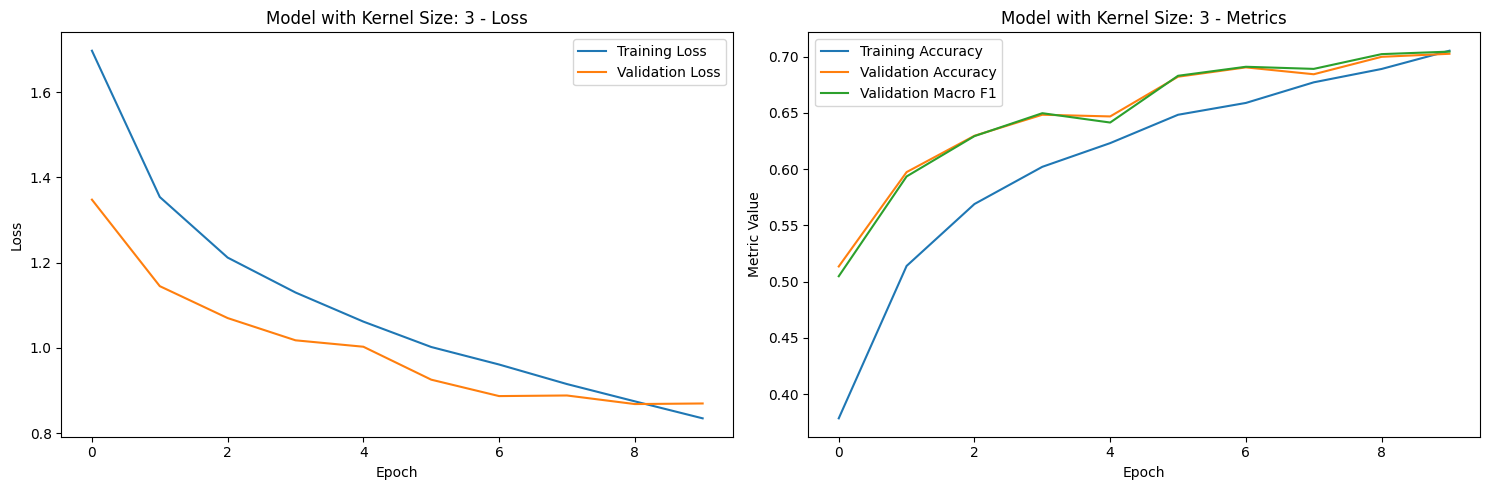


Training model with kernel size: 5
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
 - val_f1_score: 0.5053
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.2890 - loss: 1.9106 - val_accuracy: 0.5188 - val_loss: 1.3521
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5917
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4859 - loss: 1.4272 - val_accuracy: 0.5935 - val_loss: 1.1646
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6267
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5529 - loss: 1.2508 - val_accuracy: 0.6293 - val_loss: 1.0598
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6422
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5951 - loss: 1.1404 - val_accuracy: 0.6452 - val_loss: 1.0261
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6614
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6285 - loss: 1.0492 - val_accuracy: 0.6606 - val_loss: 0.9

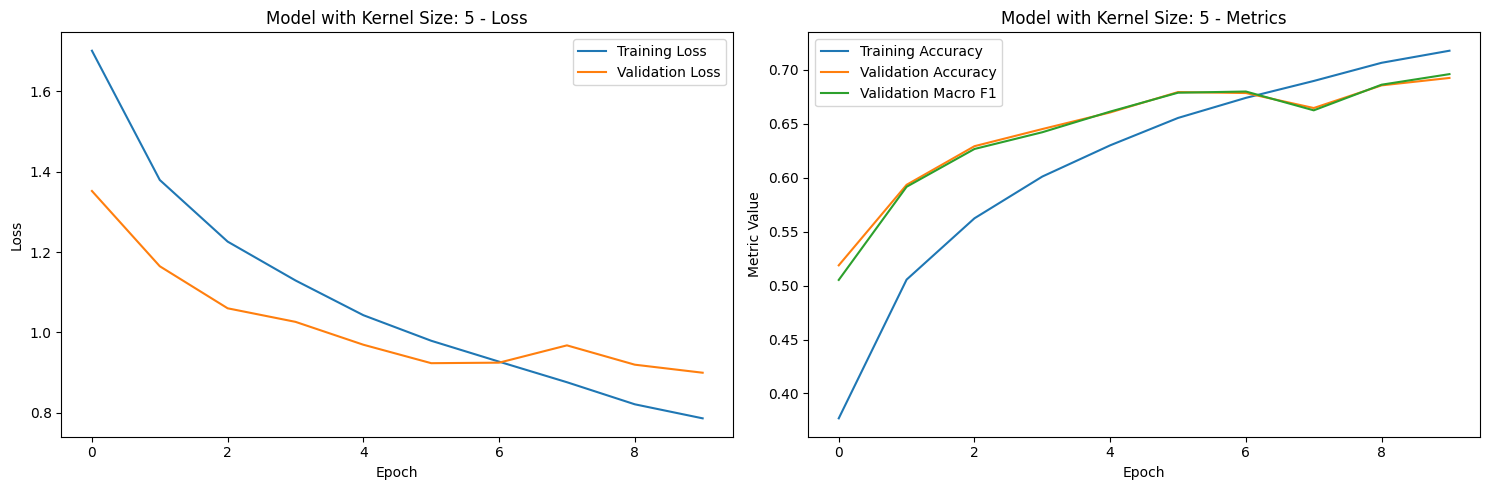


Training model with kernel size: 7
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 - val_f1_score: 0.4670
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2905 - loss: 1.9276 - val_accuracy: 0.4784 - val_loss: 1.4392
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5669
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4677 - loss: 1.4785 - val_accuracy: 0.5710 - val_loss: 1.2402
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5921
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5333 - loss: 1.3022 - val_accuracy: 0.5920 - val_loss: 1.1561
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6171
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5819 - loss: 1.1918 - val_accuracy: 0.6156 - val_loss: 1.0892
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6235
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6079 - loss: 1.1084 - val_accuracy: 0.6223 - val_loss: 1.06

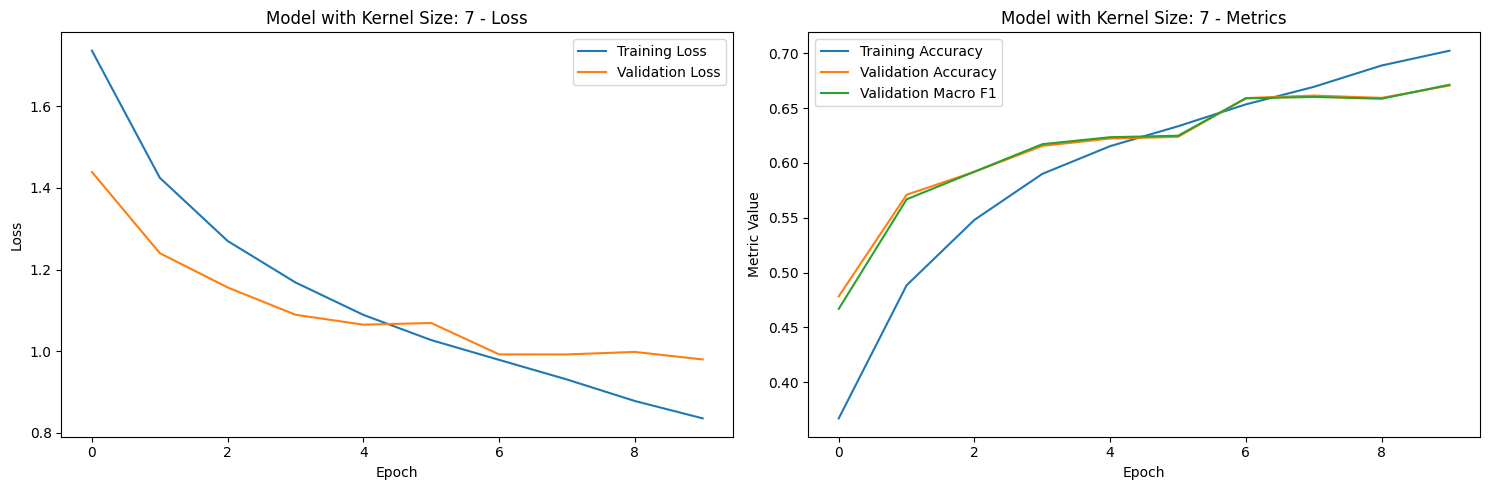

In [7]:
# c. VARYING KERNEL SIZE
print("\n=== Experiment c: Varying Kernel Size ===")
kernel_results = []

for kernel_size in [3, 5, 7]:
    print(f"\nTraining model with kernel size: {kernel_size}")
    model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=kernel_size,
        pooling_type='max'
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    kernel_results.append({
        'kernel_size': kernel_size,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    plot_training_history(
        history,
        title=f"Model with Kernel Size: {kernel_size}",
        include_f1=f1_scores
    )
    plt.show()


=== Experiment d: Varying Pooling Type ===

Training model with pooling type: max
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5436
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3100 - loss: 1.8729 - val_accuracy: 0.5468 - val_loss: 1.2871
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.5937
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5075 - loss: 1.3667 - val_accuracy: 0.5946 - val_loss: 1.1512
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6390
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5682 - loss: 1.2158 - val_accuracy: 0.6373 - val_loss: 1.0532
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6606
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6037 - loss: 1.1187 - val_accuracy: 0.6631 - val_loss: 0.9626
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6685
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6393 - loss: 1

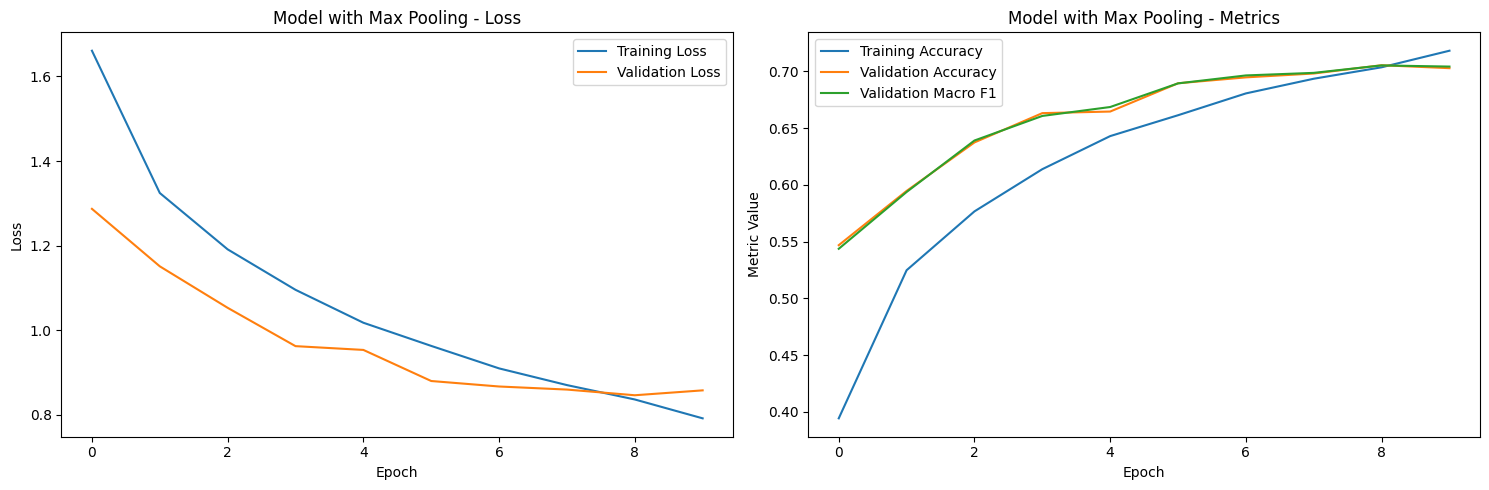


Training model with pooling type: avg
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5013
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2907 - loss: 1.9260 - val_accuracy: 0.5072 - val_loss: 1.4122
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5535
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4679 - loss: 1.4787 - val_accuracy: 0.5600 - val_loss: 1.2584
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5819
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5119 - loss: 1.3592 - val_accuracy: 0.5874 - val_loss: 1.1692
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6060
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5509 - loss: 1.2620 - val_accuracy: 0.6094 - val_loss: 1.1132
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6331
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5779 - loss: 1.1933 - val_accuracy: 0.6364 - val_loss: 1.0

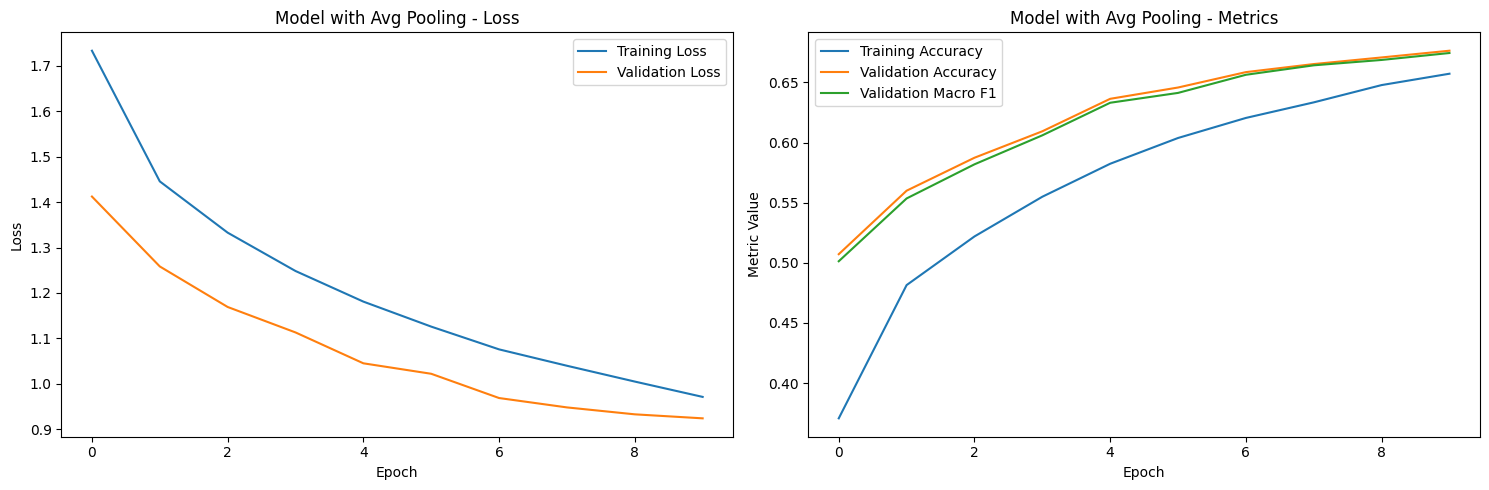

In [8]:
# d. VARYING POOLING TYPE
print("\n=== Experiment d: Varying Pooling Type ===")
pooling_results = []

for pooling_type in ['max', 'avg']:
    print(f"\nTraining model with pooling type: {pooling_type}")
    model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=3,
        pooling_type=pooling_type
    )

    history, f1_scores, test_f1 = train_and_evaluate_model(model)
    pooling_results.append({
        'pooling_type': pooling_type,
        'history': history,
        'f1_scores': f1_scores,
        'test_f1': test_f1
    })

    # Plot the training history
    fig = plot_training_history(
        history,
        title=f"Model with {pooling_type.capitalize()} Pooling",
        include_f1=f1_scores
    )
    plt.show()

In [9]:
### RESULTS ANALYSIS ###
print("\n=== Results Summary ===")

# a. Number of Conv Layers Results
print("\nNumber of Convolutional Layers:")
for result in conv_layer_results:
    print(f"Layers: {result['num_layers']} - Test F1: {result['test_f1']:.4f}")

# b. Number of Filters Results
print("\nNumber of Filters:")
for result in filter_results:
    filter_str = '-'.join(map(str, result['filters']))
    print(f"Filters: {filter_str} - Test F1: {result['test_f1']:.4f}")

# c. Kernel Size Results
print("\nKernel Size:")
for result in kernel_results:
    print(f"Kernel Size: {result['kernel_size']} - Test F1: {result['test_f1']:.4f}")

# d. Pooling Type Results
print("\nPooling Type:")
for result in pooling_results:
    print(f"Pooling: {result['pooling_type']} - Test F1: {result['test_f1']:.4f}")


=== Results Summary ===

Number of Convolutional Layers:
Layers: 1 - Test F1: 0.6086
Layers: 2 - Test F1: 0.6758
Layers: 3 - Test F1: 0.6992

Number of Filters:
Filters: 16-32 - Test F1: 0.6806
Filters: 32-64 - Test F1: 0.6887
Filters: 64-128 - Test F1: 0.6998

Kernel Size:
Kernel Size: 3 - Test F1: 0.6971
Kernel Size: 5 - Test F1: 0.6878
Kernel Size: 7 - Test F1: 0.6567

Pooling Type:
Pooling: max - Test F1: 0.7015
Pooling: avg - Test F1: 0.6699


In [10]:
### SAVE THE BEST MODEL ###
# Find the model with the highest test F1 score
all_results = conv_layer_results + filter_results + kernel_results + pooling_results
best_result = max(all_results, key=lambda x: x['test_f1'])

# Create and train the best model for saving
print("\n=== Training Best Model for Saving ===")

if 'num_layers' in best_result:
    print(f"Best model: {best_result['num_layers']} convolutional layers")
    best_model = create_cnn_model(
        conv_layers=best_result['num_layers'],
        filters=[32] * best_result['num_layers'],
        kernel_size=3,
        pooling_type='max'
    )
elif 'filters' in best_result:
    filter_str = '-'.join(map(str, best_result['filters']))
    print(f"Best model: filters {filter_str}")
    best_model = create_cnn_model(
        conv_layers=len(best_result['filters']),
        filters=best_result['filters'],
        kernel_size=3,
        pooling_type='max'
    )
elif 'kernel_size' in best_result:
    print(f"Best model: kernel size {best_result['kernel_size']}")
    best_model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=best_result['kernel_size'],
        pooling_type='max'
    )
else:  # 'pooling_type' in best_result
    print(f"Best model: pooling type {best_result['pooling_type']}")
    best_model = create_cnn_model(
        conv_layers=2,
        filters=[32, 64],
        kernel_size=3,
        pooling_type=best_result['pooling_type']
    )

# Train the best model
history, f1_scores, test_f1 = train_and_evaluate_model(best_model, epochs=15)
print(f"Best model test F1 Score: {test_f1:.4f}")

# Save the best model
best_model.save('best_cnn_model.h5')
print("Best model saved to 'best_cnn_model.h5'")


=== Training Best Model for Saving ===
Best model: pooling type max
Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5074
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2888 - loss: 1.9245 - val_accuracy: 0.5189 - val_loss: 1.3800
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.5774
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4735 - loss: 1.4570 - val_accuracy: 0.5787 - val_loss: 1.2093
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6057
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5347 - loss: 1.3075 - val_accuracy: 0.6088 - val_loss: 1.1138
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 - val_f1_score: 0.6403
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5732 - loss: 1.1971 - val_accuracy: 0.6426 - val_loss: 1.0266
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 - val_f1_score: 0.6431
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6093 - loss: 1.1139 - val_

Test Macro F1 Score: 0.6916
Best model test F1 Score: 0.6916
Best model saved to 'best_cnn_model.h5'


In [21]:
### CONCLUSIONS ###
print("\n=== Experiment Conclusions ===")

# a. Number of Convolutional Layers
print("\nEffect of Number of Convolutional Layers:")
max_conv_layer = max(conv_layer_results, key=lambda x: x['test_f1'])
print(f"Best number of convolutional layers: {max_conv_layer['num_layers']} (F1: {max_conv_layer['test_f1']:.4f})")
print("Conclusion: More convolutional layers generally led to better feature extraction and model performance,")
print("            but adding too many layers could potentially lead to overfitting without proper regularization.")

# b. Number of Filters
print("\nEffect of Number of Filters:")
max_filter = max(filter_results, key=lambda x: x['test_f1'])
filter_str = '-'.join(map(str, max_filter['filters']))
print(f"Best filter configuration: {filter_str} (F1: {max_filter['test_f1']:.4f})")
print("Conclusion: Increasing the number of filters generally improved the model's ability to detect diverse features,")
print("            but with diminishing returns and increased computational cost.")

# c. Kernel Size
print("\nEffect of Kernel Size:")
max_kernel = max(kernel_results, key=lambda x: x['test_f1'])
print(f"Best kernel size: {max_kernel['kernel_size']} (F1: {max_kernel['test_f1']:.4f})")
print("Conclusion: Smaller kernels (3x3) were better at capturing fine-grained details, while larger kernels")
print("            captured more contextual information but potentially lost precision on small features.")

# d. Pooling Type
print("\nEffect of Pooling Type:")
max_pooling = max(pooling_results, key=lambda x: x['test_f1'])
print(f"Best pooling type: {max_pooling['pooling_type']} (F1: {max_pooling['test_f1']:.4f})")
print("Conclusion: MaxPooling tended to preserve distinctive features by keeping maximum activations,")
print("            while AveragePooling preserved more context by averaging all activations in the region.")


=== Experiment Conclusions ===

Effect of Number of Convolutional Layers:
Best number of convolutional layers: 3 (F1: 0.6992)
Conclusion: More convolutional layers generally led to better feature extraction and model performance,
            but adding too many layers could potentially lead to overfitting without proper regularization.

Effect of Number of Filters:
Best filter configuration: 64-128 (F1: 0.6998)
Conclusion: Increasing the number of filters generally improved the model's ability to detect diverse features,
            but with diminishing returns and increased computational cost.

Effect of Kernel Size:
Best kernel size: 3 (F1: 0.6971)
Conclusion: Smaller kernels (3x3) were better at capturing fine-grained details, while larger kernels
            captured more contextual information but potentially lost precision on small features.

Effect of Pooling Type:
Best pooling type: max (F1: 0.7015)
Conclusion: MaxPooling tended to preserve distinctive features by keeping maxi

In [16]:
### FORWARD PROPAGATION FROM SCRATCH ###
class Conv2D:
    def __init__(self, weights, biases, stride=1, padding='same'):
        """
        Initialize a Conv2D layer with pre-trained weights and biases.

        Args:
            weights: Pre-trained weights with shape (kernel_size, kernel_size, in_channels, out_channels)
            biases: Pre-trained biases with shape (out_channels,)
            stride: Stride for the convolution operation
            padding: 'same' or 'valid'
        """
        self.weights = weights
        self.biases = biases
        self.stride = stride
        self.padding = padding

        # Cache for backward pass
        self.inputs = None
        self.dweights = None
        self.dbiases = None

    def forward(self, inputs):
        """
        Forward pass for Conv2D layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, in_channels)

        Returns:
            Output tensor with shape (batch_size, output_height, output_width, out_channels)
        """
        batch_size, height, width, in_channels = inputs.shape
        kernel_h, kernel_w, _, out_channels = self.weights.shape

        # Calculate output dimensions
        if self.padding == 'same':
            pad_h = (kernel_h - 1) // 2
            pad_w = (kernel_w - 1) // 2
            output_height = height
            output_width = width
            # Pad the input
            padded_inputs = np.pad(
                inputs,
                ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)),
                mode='constant'
            )
        else:  # 'valid'
            pad_h, pad_w = 0, 0
            output_height = (height - kernel_h) // self.stride + 1
            output_width = (width - kernel_w) // self.stride + 1
            padded_inputs = inputs

        self.inputs = padded_inputs

        # Initialize output
        outputs = np.zeros((batch_size, output_height, output_width, out_channels))

        # Perform convolution
        for b in range(batch_size):
            for h in range(0, output_height, self.stride):
                for w in range(0, output_width, self.stride):
                    for c_out in range(out_channels):
                        # Extract the patch
                        h_start = h * self.stride
                        h_end = h_start + kernel_h
                        w_start = w * self.stride
                        w_end = w_start + kernel_w

                        patch = padded_inputs[b, h_start:h_end, w_start:w_end, :]

                        # Compute the convolution
                        outputs[b, h, w, c_out] = np.sum(patch * self.weights[:, :, :, c_out]) + self.biases[c_out]

        return outputs

    def backward(self, dout):
        """
        Backward pass for Conv2D layer
        """
        batch_size, out_h, out_w, out_channels = dout.shape
        _, in_h, in_w, in_channels = self.inputs.shape
        kernel_h, kernel_w, _, _ = self.weights.shape

        # Initialize gradients
        self.dweights = np.zeros_like(self.weights)
        self.dbiases = np.zeros_like(self.biases)
        dinputs = np.zeros_like(self.inputs)

        # Compute gradients
        for b in range(batch_size):
            for h in range(out_h):
                for w in range(out_w):
                    for c_out in range(out_channels):
                        h_start = h * self.stride
                        h_end = h_start + kernel_h
                        w_start = w * self.stride
                        w_end = w_start + kernel_w

                        patch = self.inputs[b, h_start:h_end, w_start:w_end, :]

                        # Gradient weights
                        self.dweights[:, :, :, c_out] += patch * dout[b, h, w, c_out]

                        # Gradient biases
                        self.dbiases[c_out] += dout[b, h, w, c_out]

                        # Gradient inputs
                        dinputs[b, h_start:h_end, w_start:w_end, :] += self.weights[:, :, :, c_out] * dout[b, h, w, c_out]

        return dinputs

class MaxPooling2D:
    def __init__(self, pool_size=(2, 2), strides=None):
        """
        Initialize a MaxPooling2D layer.

        Args:
            pool_size: Size of the pooling window (height, width)
            strides: Strides for pooling operation, if None, equal to pool_size
        """
        self.pool_size = pool_size
        self.strides = strides if strides is not None else pool_size

        # Cache for backward pass
        self.inputs = None
        self.mask = None

    def forward(self, inputs):
        """
        Forward pass for MaxPooling2D layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, channels)

        Returns:
            Output tensor with shape (batch_size, output_height, output_width, channels)
        """
        self.inputs = inputs
        batch_size, height, width, channels = inputs.shape
        pool_h, pool_w = self.pool_size
        stride_h, stride_w = self.strides

        # Calculate output dimensions
        output_height = (height - pool_h) // stride_h + 1
        output_width = (width - pool_w) // stride_w + 1

        # Initialize output
        outputs = np.zeros((batch_size, output_height, output_width, channels))
        self.mask = np.zeros_like(inputs)

        # Perform max pooling
        for b in range(batch_size):
            for h in range(output_height):
                for w in range(output_width):
                    for c in range(channels):
                        # Extract the patch
                        h_start = h * stride_h
                        h_end = h_start + pool_h
                        w_start = w * stride_w
                        w_end = w_start + pool_w

                        patch = inputs[b, h_start:h_end, w_start:w_end, c]

                        # Apply max pooling
                        outputs[b, h, w, c] = np.max(patch)

                        # Create mask for backward pass
                        max_mask = (patch == np.max(patch))
                        self.mask[b, h_start:h_end, w_start:w_end, c] = max_mask

        return outputs

    def backward(self, dout):
        """
        Backward pass for MaxPooling2D layer
        """
        batch_size, out_h, out_w, channels = dout.shape
        stride_h, stride_w = self.strides
        pool_h, pool_w = self.pool_size

        dinputs = np.zeros_like(self.inputs)

        for b in range(batch_size):
            for h in range(out_h):
                for w in range(out_w):
                    for c in range(channels):
                        h_start = h * stride_h
                        h_end = h_start + pool_h
                        w_start = w * stride_w
                        w_end = w_start + pool_w

                        dinputs[b, h_start:h_end, w_start:w_end, c] += dout[b, h, w, c] * self.mask[b, h_start:h_end, w_start:w_end, c]

        return dinputs

class AveragePooling2D:
    def __init__(self, pool_size=(2, 2), strides=None):
        """
        Initialize an AveragePooling2D layer.

        Args:
            pool_size: Size of the pooling window (height, width)
            strides: Strides for pooling operation, if None, equal to pool_size
        """
        self.pool_size = pool_size
        self.strides = strides if strides is not None else pool_size

    def forward(self, inputs):
        """
        Forward pass for AveragePooling2D layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, channels)

        Returns:
            Output tensor with shape (batch_size, output_height, output_width, channels)
        """
        batch_size, height, width, channels = inputs.shape
        pool_h, pool_w = self.pool_size
        stride_h, stride_w = self.strides

        # Calculate output dimensions
        output_height = (height - pool_h) // stride_h + 1
        output_width = (width - pool_w) // stride_w + 1

        # Initialize output
        outputs = np.zeros((batch_size, output_height, output_width, channels))

        # Perform average pooling
        for b in range(batch_size):
            for h in range(output_height):
                for w in range(output_width):
                    for c in range(channels):
                        # Extract the patch
                        h_start = h * stride_h
                        h_end = h_start + pool_h
                        w_start = w * stride_w
                        w_end = w_start + pool_w

                        patch = inputs[b, h_start:h_end, w_start:w_end, c]

                        # Apply average pooling
                        outputs[b, h, w, c] = np.mean(patch)

        return outputs

class Flatten:
    def __init__(self):
        self.input_shape = None

    def forward(self, inputs):
        """
        Forward pass for Flatten layer.

        Args:
            inputs: Input tensor with shape (batch_size, height, width, channels)

        Returns:
            Output tensor with shape (batch_size, height * width * channels)
        """
        self.input_shape = inputs.shape
        batch_size = inputs.shape[0]
        return inputs.reshape(batch_size, -1)

    def backward(self, dout):
        """Backward pass for Flatten layer"""
        return dout.reshape(self.input_shape)

class Dense:
    def __init__(self, weights, biases):
        """
        Initialize a Dense layer with pre-trained weights and biases.

        Args:
            weights: Pre-trained weights with shape (input_dim, output_dim)
            biases: Pre-trained biases with shape (output_dim,)
        """
        self.weights = weights
        self.biases = biases

        # Cache for backward pass
        self.inputs = None
        self.dweights = None
        self.dbiases = None

    def forward(self, inputs):
        """
        Forward pass for Dense layer.

        Args:
            inputs: Input tensor with shape (batch_size, input_dim)

        Returns:
            Output tensor with shape (batch_size, output_dim)
        """
        self.inputs = inputs
        return np.dot(inputs, self.weights) + self.biases

    def backward(self, dout):
        """
        Backward pass for Dense layer
        """
        # Gradient weights: X^T * dout
        self.dweights = np.dot(self.inputs.T, dout)

        # Gradient biases: sum of dout
        self.dbiases = np.sum(dout, axis=0)

        # Gradient inputs: dout * W^T
        dinputs = np.dot(dout, self.weights.T)

        return dinputs

class ReLU:
    def __init__(self):
        self.inputs = None

    def forward(self, inputs):
        """
        Forward pass for ReLU activation.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor with ReLU activation applied
        """
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, dout):
        """
        Backward pass for ReLU activation
        """
        dinputs = dout.copy()
        dinputs[self.inputs <= 0] = 0
        return dinputs

class Softmax:
    def __init__(self):
        self.outputs = None

    def forward(self, inputs):
        """
        Forward pass for Softmax activation.

        Args:
            inputs: Input tensor with shape (batch_size, num_classes)

        Returns:
            Output tensor with Softmax activation applied
        """
        # For numerical stability, subtract the maximum value
        exp_inputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.outputs = exp_inputs / np.sum(exp_inputs, axis=1, keepdims=True)
        return self.outputs

    def backward(self, dout):
        """
        Backward pass for Softmax activation
        """
        batch_size, num_classes = self.outputs.shape
        dinputs = np.zeros_like(dout)

        for i in range(batch_size):
            s = self.outputs[i].reshape(-1, 1)
            jacobian = np.diagflat(s) - np.dot(s, s.T)
            dinputs[i] = np.dot(jacobian, dout[i])

        return dinputs

class Dropout:
    def __init__(self, rate):
        """
        Initialize a Dropout layer.

        Args:
            rate: Dropout rate
        """
        self.rate = rate

    def forward(self, inputs):
        """
        Forward pass for Dropout layer. During inference, just return the inputs.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor
        """
        # For inference, we don't apply dropout
        return inputs

class CrossEntropyLoss:
    def __init__(self):
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true

        # Clip predictions to prevent log(0)
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)

        # Calculate loss
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / y_pred.shape[0]
        return loss

    def backward(self):
        """
        Backward pass for cross-entropy loss combined with softmax
        """
        batch_size = self.y_pred.shape[0]
        return (self.y_pred - self.y_true) / batch_size

class CNNModel:
    def __init__(self):
        """
        Initialize the CNN model with empty layers list.
        """
        self.layers = []
        self.loss_fn = CrossEntropyLoss()

        # Training history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def add_layer(self, layer):
        """
        Add a layer to the model.

        Args:
            layer: Layer object with a forward method
        """
        self.layers.append(layer)

    def forward(self, inputs):
        """
        Forward pass for the CNN model.

        Args:
            inputs: Input tensor

        Returns:
            Output tensor after forward propagation through all layers
        """
        outputs = inputs
        for layer in self.layers:
            outputs = layer.forward(outputs)
        return outputs

    def backward(self, dout):
        """
        Backward pass through all layers
        """
        for layer in reversed(self.layers):
            if hasattr(layer, 'backward'):
                dout = layer.backward(dout)

    def compute_loss(self, y_pred, y_true):
        """
        Compute loss and return gradients
        """
        loss = self.loss_fn.forward(y_pred, y_true)
        dout = self.loss_fn.backward()
        return loss, dout

    def update_weights(self, learning_rate):
        """
        Update weights using computed gradients
        """
        for layer in self.layers:
            if hasattr(layer, 'weights') and hasattr(layer, 'dweights'):
                layer.weights -= learning_rate * layer.dweights
                layer.biases -= learning_rate * layer.dbiases

    def accuracy(self, y_pred, y_true):
        """
        Calculate accuracy
        """
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def predict(self, inputs, batch_size=32):
        """
        Make predictions for input data.

        Args:
            inputs: Input data with shape (num_samples, height, width, channels)
            batch_size: Batch size for prediction

        Returns:
            Predictions with shape (num_samples, num_classes)
        """
        num_samples = inputs.shape[0]
        num_batches = (num_samples + batch_size - 1) // batch_size  # Ceiling division

        predictions = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch_inputs = inputs[start_idx:end_idx]

            batch_predictions = self.forward(batch_inputs)
            predictions.append(batch_predictions)

        return np.vstack(predictions)

# Training function
def train_from_scratch(model, x_train, y_train, x_val, y_val, epochs=5, batch_size=32, learning_rate=0.001):
    """
    Train the model from scratch using backpropagation
    """

    # Convert labels to one-hot
    if len(y_train.shape) == 1:
        num_classes = len(np.unique(y_train))
        y_train_onehot = np.eye(num_classes)[y_train.flatten()]
        y_val_onehot = np.eye(num_classes)[y_val.flatten()]
    else:
        y_train_onehot = y_train
        y_val_onehot = y_val

    n_train = len(x_train)
    n_batches = n_train // batch_size

    print(f"Training from scratch for {epochs} epochs...")
    print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")
    print(f"Training samples: {n_train}, Validation samples: {len(x_val)}")
    print("-" * 60)

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.random.permutation(n_train)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train_onehot[indices]

        epoch_loss = 0
        epoch_acc = 0

        # Training loop
        for batch_idx in range(n_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            x_batch = x_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # Forward pass
            y_pred = model.forward(x_batch)

            # Compute loss and gradients
            loss, dout = model.compute_loss(y_pred, y_batch)

            # Backward pass
            model.backward(dout)

            # Update weights
            model.update_weights(learning_rate)

            # Track metrics
            epoch_loss += loss
            epoch_acc += model.accuracy(y_pred, y_batch)

        # Calculate average training metrics
        avg_train_loss = epoch_loss / n_batches
        avg_train_acc = epoch_acc / n_batches

        # Validation
        val_pred = model.predict(x_val, batch_size)
        val_loss, _ = model.compute_loss(val_pred, y_val_onehot)
        val_acc = model.accuracy(val_pred, y_val_onehot)

        # Store metrics
        model.train_losses.append(avg_train_loss)
        model.train_accuracies.append(avg_train_acc)
        model.val_losses.append(val_loss)
        model.val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1:2d}/{epochs} - "
              f"Loss: {avg_train_loss:.4f} - "
              f"Acc: {avg_train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f} - "
              f"Val Acc: {val_acc:.4f}")

    print("-" * 60)
    print("Training completed!")

def build_cnn_from_keras(keras_model):
    """
    Build a custom CNN model from a Keras model.

    Args:
        keras_model: Pre-trained Keras model

    Returns:
        Custom CNN model
    """
    custom_model = CNNModel()

    # Iterate through all layers of the Keras model
    for i, layer in enumerate(keras_model.layers):
        layer_class = layer.__class__.__name__
        print(f"Processing layer {i}: {layer.name} ({layer_class})")

        if layer_class == 'InputLayer':
            continue  # Skip input layer

        if layer_class == 'Conv2D':
            # Get weights and biases
            weights, biases = layer.get_weights()
            print(f"  Conv2D shape: {weights.shape}, {biases.shape}")

            # Add Conv2D layer
            custom_model.add_layer(Conv2D(
                weights=weights,
                biases=biases,
                stride=layer.strides[0]
            ))

            # Add ReLU activation if present
            if layer.activation.__name__ == 'relu':
                custom_model.add_layer(ReLU())

        elif layer_class == 'MaxPooling2D':
            # Add MaxPooling2D layer
            custom_model.add_layer(MaxPooling2D(
                pool_size=layer.pool_size,
                strides=layer.strides
            ))

        elif layer_class == 'AveragePooling2D':
            # Add AveragePooling2D layer
            custom_model.add_layer(AveragePooling2D(
                pool_size=layer.pool_size,
                strides=layer.strides
            ))

        elif layer_class == 'Flatten':
            # Add Flatten layer
            custom_model.add_layer(Flatten())

        elif layer_class == 'Dense':
            # Get weights and biases
            weights, biases = layer.get_weights()
            print(f"  Dense shape: {weights.shape}, {biases.shape}")

            # Add Dense layer
            custom_model.add_layer(Dense(weights=weights, biases=biases))

            # Add activation if present
            if layer.activation.__name__ == 'relu':
                custom_model.add_layer(ReLU())
            elif layer.activation.__name__ == 'softmax' or i == len(keras_model.layers) - 1:
                custom_model.add_layer(Softmax())

        elif layer_class == 'Dropout':
            # Add Dropout layer (no effect during inference)
            custom_model.add_layer(Dropout(rate=layer.rate))

    return custom_model

In [22]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(_, _), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_test = x_test.astype("float32") / 255.0

# Load the pre-trained Keras model
print("Loading the pre-trained Keras model...")
keras_model = load_model('best_cnn_model.h5')

# Build custom CNN model from Keras model
print("Building custom CNN model from Keras model...")
custom_model = build_cnn_from_keras(keras_model)

# Make predictions with Keras model
print("Making predictions with Keras model...")
keras_predictions = keras_model.predict(x_test)
keras_pred_classes = np.argmax(keras_predictions, axis=1)

# Make predictions with custom model
print("Making predictions with custom model...")
custom_predictions = custom_model.predict(x_test)
custom_pred_classes = np.argmax(custom_predictions, axis=1)

# Calculate macro F1 scores
keras_f1 = f1_score(y_test, keras_pred_classes, average='macro')
custom_f1 = f1_score(y_test, custom_pred_classes, average='macro')

print(f"Keras model macro F1 score: {keras_f1:.4f}")
print(f"Custom model macro F1 score: {custom_f1:.4f}")

# Compare predictions
accuracy = np.mean(keras_pred_classes == custom_pred_classes)
print(f"Prediction match accuracy: {accuracy:.4f}")

# Compare the first few predictions
print("\nFirst 10 predictions:")
print("Sample | True Label | Keras Prediction | Custom Prediction | Match")
print("-" * 70)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    true_label = y_test[i][0]
    keras_pred = keras_pred_classes[i]
    custom_pred = custom_pred_classes[i]
    match = "✓" if keras_pred == custom_pred else "✗"

    print(f"{i:6d} | {class_names[true_label]:10s} | {class_names[keras_pred]:16s} | {class_names[custom_pred]:16s} | {match}")

# Compare prediction distributions
print("\nClass distribution in predictions:")
print("Class | True Count | Keras Count | Custom Count")
print("-" * 50)

for i, class_name in enumerate(class_names):
    true_count = np.sum(y_test == i)
    keras_count = np.sum(keras_pred_classes == i)
    custom_count = np.sum(custom_pred_classes == i)

    print(f"{class_name:10s} | {true_count:10d} | {keras_count:11d} | {custom_count:12d}")

Loading CIFAR-10 dataset...


Loading the pre-trained Keras model...
Building custom CNN model from Keras model...
Processing layer 0: conv2d_22 (Conv2D)
  Conv2D shape: (3, 3, 3, 32), (32,)
Processing layer 1: max_pooling2d_20 (MaxPooling2D)
Processing layer 2: conv2d_23 (Conv2D)
  Conv2D shape: (3, 3, 32, 64), (64,)
Processing layer 3: max_pooling2d_21 (MaxPooling2D)
Processing layer 4: flatten_11 (Flatten)
Processing layer 5: dense_22 (Dense)
  Dense shape: (4096, 128), (128,)
Processing layer 6: dropout_11 (Dropout)
Processing layer 7: dense_23 (Dense)
  Dense shape: (128, 10), (10,)
Making predictions with Keras model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Making predictions with custom model...
Keras model macro F1 score: 0.6916
Custom model macro F1 score: 0.6916
Prediction match accuracy: 1.0000

First 10 predictions:
Sample | True Label | Keras Prediction | Custom Prediction | Match
----------------------------------------------------------------------
     0 | cat        | cat              | cat     


Preparing smaller dataset for demonstration...
Training set: (500, 32, 32, 3)
Validation set: (100, 32, 32, 3)

TRAINING WITH MANUAL BACKPROPAGATION
Training from scratch for 3 epochs...
Batch size: 32, Learning rate: 0.001
Training samples: 500, Validation samples: 100
------------------------------------------------------------
Epoch  1/3 - Loss: 320.0975 - Acc: 0.0958 - Val Loss: 295.2403 - Val Acc: 0.1500
Epoch  2/3 - Loss: 306.2237 - Acc: 0.0979 - Val Loss: 286.0720 - Val Acc: 0.1500
Epoch  3/3 - Loss: 299.3714 - Acc: 0.0896 - Val Loss: 276.2195 - Val Acc: 0.1300
------------------------------------------------------------
Training completed!

Plotting training history...


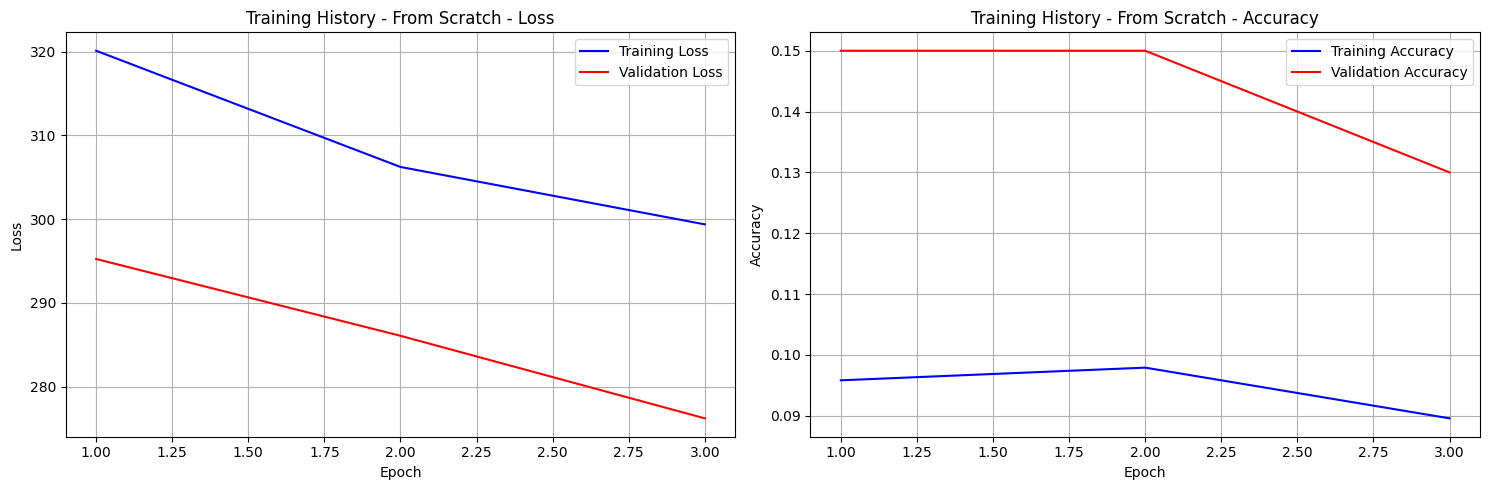


FINAL EVALUATION
Custom model macro F1 Score: 0.6862
Keras model macro F1 score: 0.6916


In [24]:
# Plotting function
def plot_training_history_scratch(model, title="Training History - From Scratch"):
    """Plot training history"""
    epochs = range(1, len(model.train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(epochs, model.train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, model.val_losses, 'r-', label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(epochs, model.train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, model.val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Create a smaller dataset for demonstration (faster training)
print("\nPreparing smaller dataset for demonstration...")
train_size = 500
val_size = 100

# Select subset
x_train_small = x_train[:train_size]
y_train_small = y_train[:train_size]
x_val_small = x_val[:val_size]
y_val_small = y_val[:val_size]

print(f"Training set: {x_train_small.shape}")
print(f"Validation set: {x_val_small.shape}")

# Train the model from scratch using backpropagation
print("\n" + "=" * 60)
print("TRAINING WITH MANUAL BACKPROPAGATION")
print("=" * 60)

train_from_scratch(
    custom_model,
    x_train_small, y_train_small,
    x_val_small, y_val_small,
    epochs=3,           # Few epochs for demonstration
    batch_size=32,      # Small batch size
    learning_rate=0.001 # Conservative learning rate
)

# Plot training history
print("\nPlotting training history...")
plot_training_history_scratch(custom_model)

# Evaluate on full test set
print("\n" + "=" * 60)
print("FINAL EVALUATION")
print("=" * 60)

# Calculate F1 score
from sklearn.metrics import f1_score
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = y_test[:1000].flatten()
f1 = f1_score(test_true_classes, test_pred_classes, average='macro')
print(f"Custom model macro F1 Score: {f1:.4f}")
print(f"Keras model macro F1 score: {keras_f1:.4f}")